# Geotechnical Toolkit Demonstration
3D visualization of investigation data and parametrically interpreted geology (i.e. a voxelized domain divided by continuous surfaces representing bedrock, or the interface between strata)  (very simple for now).

### Importing external libraries for this demonstration

In [1]:
import pyvista as pv
pv.set_jupyter_backend('static')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

#### Importing the classes used in this demonstration

In [2]:
from geotechtoolkit.project import Project, Investigation
from geotechtoolkit.geology import GeologicalModel, Surface
from geotechtoolkit.construction import ShallowFoundations

### Project class
The project class needs an ID and has a place for a description. Eventually, **Investigation** objects can be added to the project's Project.investigations dictionary and accessed by other functions later. The Project class can also contain a representation of the subsurface, represented by the **GeologicalModel**, as well as (eventually) attributes to represent earthworks or built objects.

In [3]:
demo_project = Project("DemoProj1","A demonstration project, last updated by Lucas Fabbri Oct 13 2022")
demo_project.info()

ID: DemoProj1 Description: A demonstration project, last updated by Lucas Fabbri Oct 13 2022, Contains: 0 investigations,0 earthwork elements, and 0 built elements.


### Investigation class
The investigation class handles data from geotechnical investigations using DataFrames from Pandas. There are DataFrames for collars, features, intervals and data. Collars represent the surface location of the borehole. Features are simple features, like a strata boundary or a intersection with bedrock. Intervals are regions along the borehole trace (not implemented yet). 

In [4]:
demo_investigation = Investigation()

#### Import collars from csv file containing ID, X, Y and Z info

In [5]:
demo_investigation.load_collars("./examples/demo/demo_collars.csv")
demo_investigation.collars

,ID,X,Y,Z
0,LF1,20.38,-26.67,-2.50
1,LF2,-4.68,-27.16,3.24
2,LF3,17.45,-11.70,-3.54
3,LF4,-4.36,-13.68,1.62
4,LF5,20.91,1.45,-5.71
5,LF6,-7.02,3.27,2.55


### Load sample topography and sample bedrock surface and display using PyVista
In this demo a fake topography and an fake bedrock surface are used to simulate data. The sample_bedrock mesh is created based on LiDAR data obtained from hoydedata.no for a rocky outcrop outside of Molde. The sample_topo mesh was created by smoothing and moving the bedrock surface an arbitrary distance upwards.

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


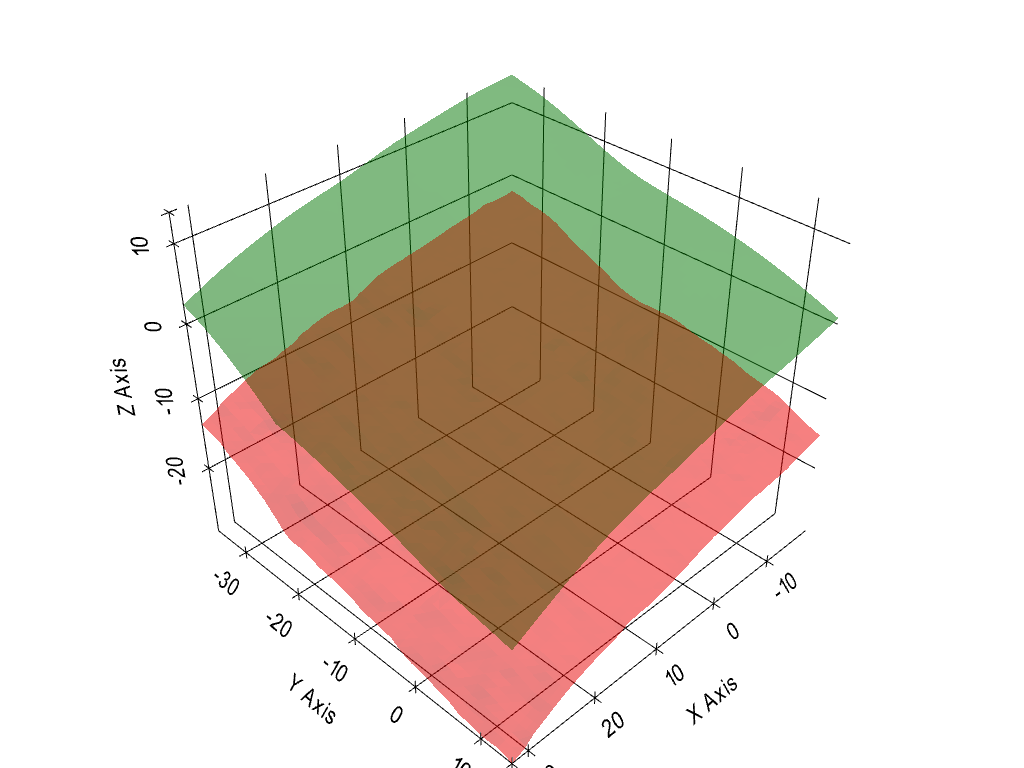

In [6]:
pv.set_plot_theme("document")
plotter = pv.Plotter()

sample_topo = pv.read("./examples/demo/sample_topo.ply")
plotter.add_mesh(sample_topo,color="green",opacity=0.5)

sample_bedrock = pv.read(r"./examples/demo/sample_bedrock.ply")
plotter.add_mesh(sample_bedrock,color="red",opacity=0.5)
plotter.show_grid()
plotter.show()


### Add some feature data
In this example we are simulating a simple depth to rock drillhole. The function simulate_intersection_feature generates feature data by ray tracing along a vertical path through the collar point.



In [7]:
from geotechtoolkit.simulation import simulate_intersection_feature
features = simulate_intersection_feature(demo_investigation,surface=sample_bedrock,description="Bedrock")
demo_investigation.load_features(features)
demo_investigation.features

,ID,Z_feature,description
0,LF1,-12.116833,Bedrock
1,LF2,-6.096994,Bedrock
2,LF3,-16.082973,Bedrock
3,LF4,-10.742972,Bedrock
4,LF5,-21.146206,Bedrock
5,LF6,-12.875176,Bedrock


### Visualize our investigation
Investigation data is visualized in pyvista, represented by text with the ID and a downwards facing cone and our features represented by discs, whose style are given in a default - but can be given to the function - dictionary defining the style based on the description of the feature. The .plotter function will either take a plotter and add meshes too it or return a plotter with the meshes.

For reference we can add the wireframe of the bedrock surface we sampled.

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


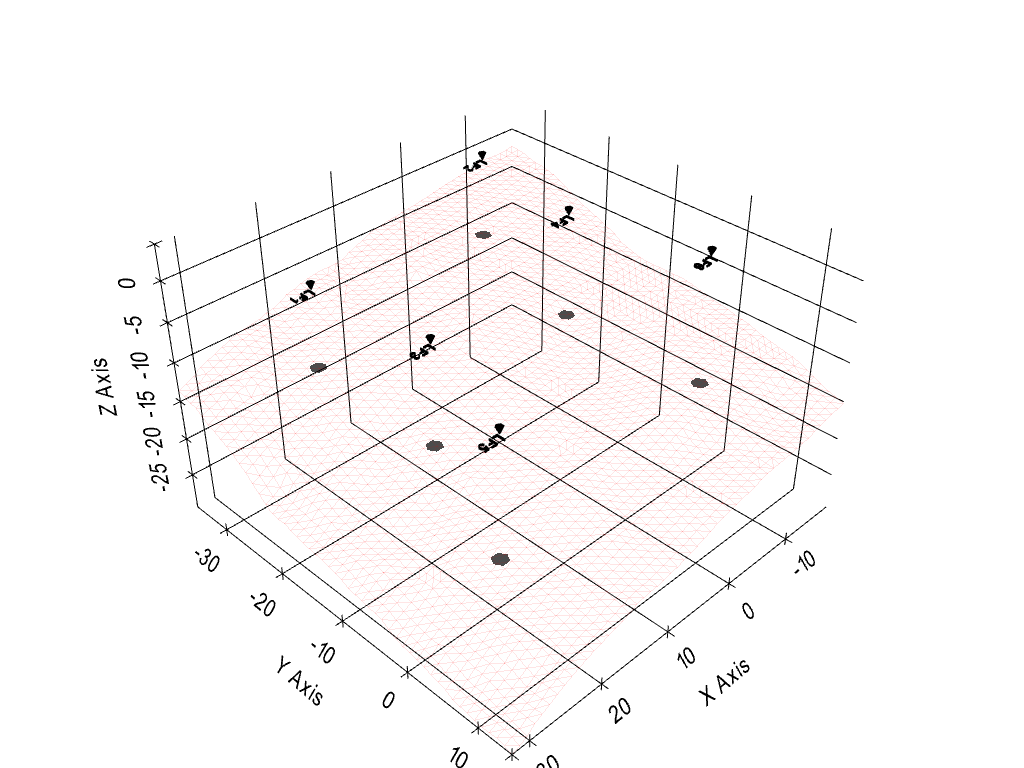

In [8]:
plotter = demo_investigation.plotter()

bedrock_edges = sample_bedrock.extract_all_edges()
bedrock_edges_actor = plotter.add_mesh(bedrock_edges,color="red",opacity=0.1)
plotter.show_grid()

plotter.show()

### Interpolating a surface
Suppose we are interested in the geology over the entire extent of our arbitrary bedrock surface. We first create a GeologicalModel object and specify a spatial domain

In [9]:
geological_model = GeologicalModel(domain = sample_bedrock.bounds)

We then create a Surface object

In [10]:
bedrock_interpolation = Surface("Bedrock")

The krige feature is then used to generate a kriged surface based on the points from our Investigation. Kriging is done using pykrige's universial kriging

In [11]:
bedrock_interpolation.krige(demo_investigation.feature_points(), domain = geological_model.domain)

geological_model.domain

(-17.66, 32.34, -35.5, 14.5, -29.63, -2.29)

We can add the variance predicted by the model and visualize it using pyvista.

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


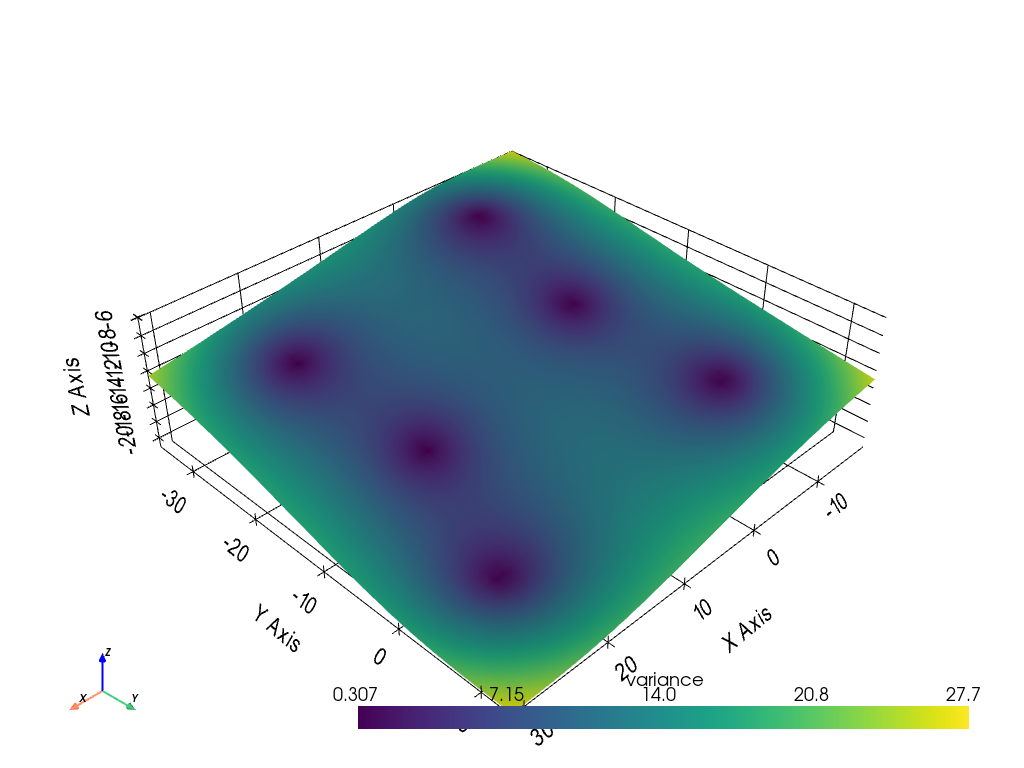

In [12]:
bedrock_interpolation.add_uncertainty_visualization()
bedrock_interpolation.surface.set_active_scalars("variance")
bedrock_interpolation.surface.plot(show_grid = True)

The universal kriging object is accessable and we can access it to use any of the PyKrige functions associated with it. We can, for example, view the variogram model.

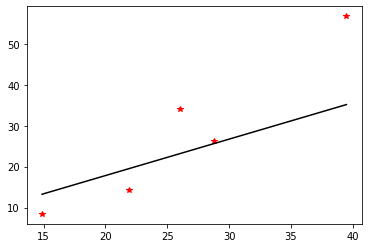

In [13]:
bedrock_interpolation.interpolation.metadata["UK"].display_variogram_model()

For fun, we can view it together with the investigation and a wireframe of our "real" bedrock surface

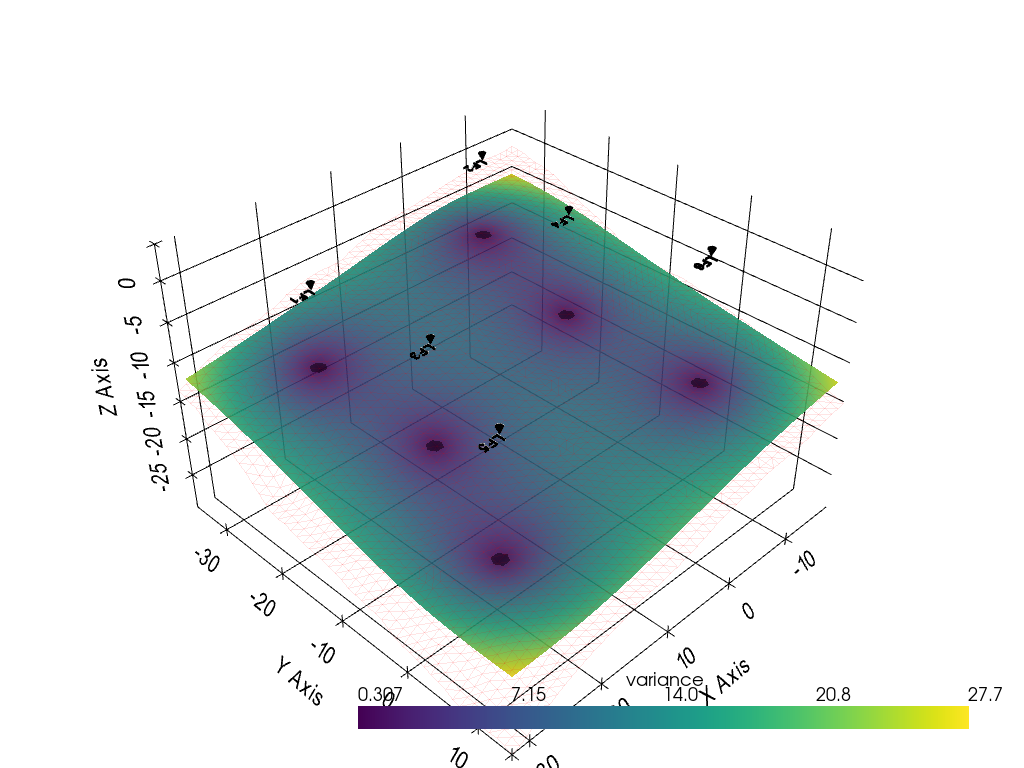

In [14]:
plotter = demo_investigation.plotter()

plotter.add_mesh(bedrock_edges,color="red",opacity=0.1)

plotter.add_mesh(bedrock_interpolation.surface, opacity = 0.9)

plotter.show_grid()
plotter.show()

## Importing construction elements from an IFC file 
Create a ShallowFoundations object, use the import_ifc function and show the info imported.
The dictionary is indexed by the GlobalID from the IFC file

In [15]:
foundations = ShallowFoundations()
foundations.import_ifc("./examples/demo/Duplex.ifc")
foundations.dictionary['0kF45Qs8L9PAM9kmb1lT5d']


{'name': 'Wall Foundation:Bearing Footing - 900 x 300:186596',
 'width': 0.8999999999999986,
 'length': 18.28299999999998,
 'elevation': -1.55,
 'polydata': PolyData (0x232f3776d00)
   N Cells:	12
   N Points:	8
   X Bounds:	8.141e+00, 9.041e+00
   Y Bounds:	-1.804e+01, 2.415e-01
   Z Bounds:	-1.550e+00, -1.250e+00
   N Arrays:	3,
 'bottom': UnstructuredGrid (0x232f3776a00)
   N Cells:	2
   N Points:	4
   X Bounds:	8.141e+00, 9.041e+00
   Y Bounds:	-1.804e+01, 2.415e-01
   Z Bounds:	-1.550e+00, -1.550e+00
   N Arrays:	3}

The imported ShallowFoundations can be visualized, for example, together with the investigation and the topograpgy

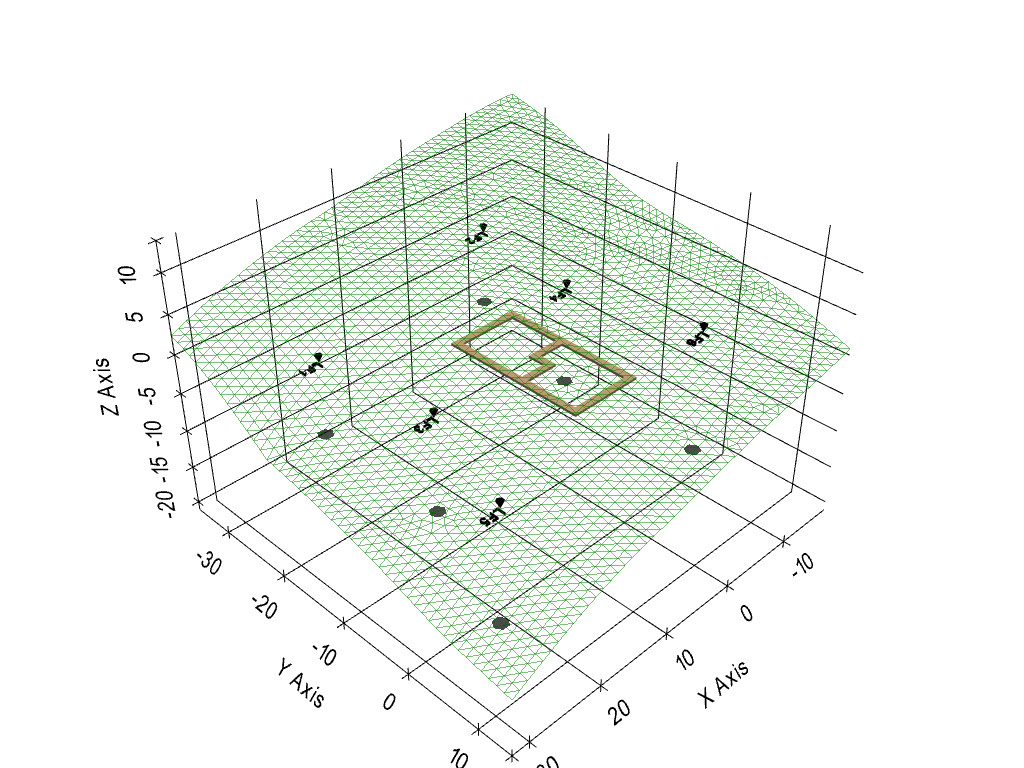

In [16]:
plotter = demo_investigation.plotter()

plotter = foundations.plotter(plotter)

plotter.add_mesh(sample_topo.extract_all_edges(),color="g", opacity=0.5)
plotter.show_grid()
plotter.show()

## Multi Layered 3D Geology Models
Randomly generated surfaces are used to generate geology over a domain. Randomly generated surfaces are used, but surfaces interpreted (as demonstrated earlier) can be used in their place.

Import some helper functions from the simulation module and specify a seed

In [18]:
from geotechtoolkit.simulation import random_field, generate_random_even_spaced_layers, apply_random_field_to_properties
SEED = 12345

Create a new GeologicalModel object and add the topography and bedrock surfaces

In [19]:
simulated_geology = GeologicalModel(domain = sample_bedrock.bounds, zMax=15, zMin = -35)

simulated_geology.add_topography(sample_topo)
simulated_geology.add_basement(sample_bedrock)

Discretize the domain, bounded by the topography and basement. Then visualize it

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


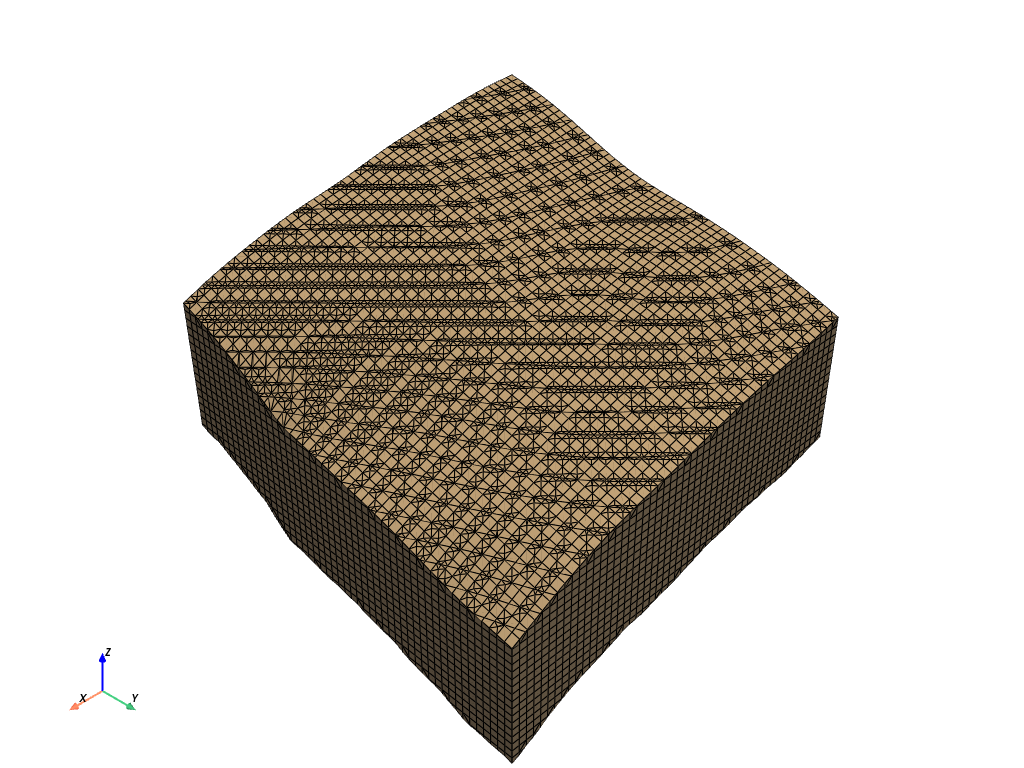

In [20]:
simulated_geology.discretize(resolution=1)
simulated_geology.grid.plot(show_edges = True)

Generate our random surfaces and add them to the "simulated_geology" - GeologicalModel object instance

In [21]:
rand_surfs = generate_random_even_spaced_layers(
        n_layers = 3,
        top_surface=simulated_geology.topography.surface, 
        bottom_surface=simulated_geology.basement.surface,
        seed=SEED
    )

for surf in rand_surfs:
    simulated_geology.add_surface(surf)
    

Subdivide our discretized domain by the surfaces, and visualize. Each domain gets given a "unit_index" increasing with depth

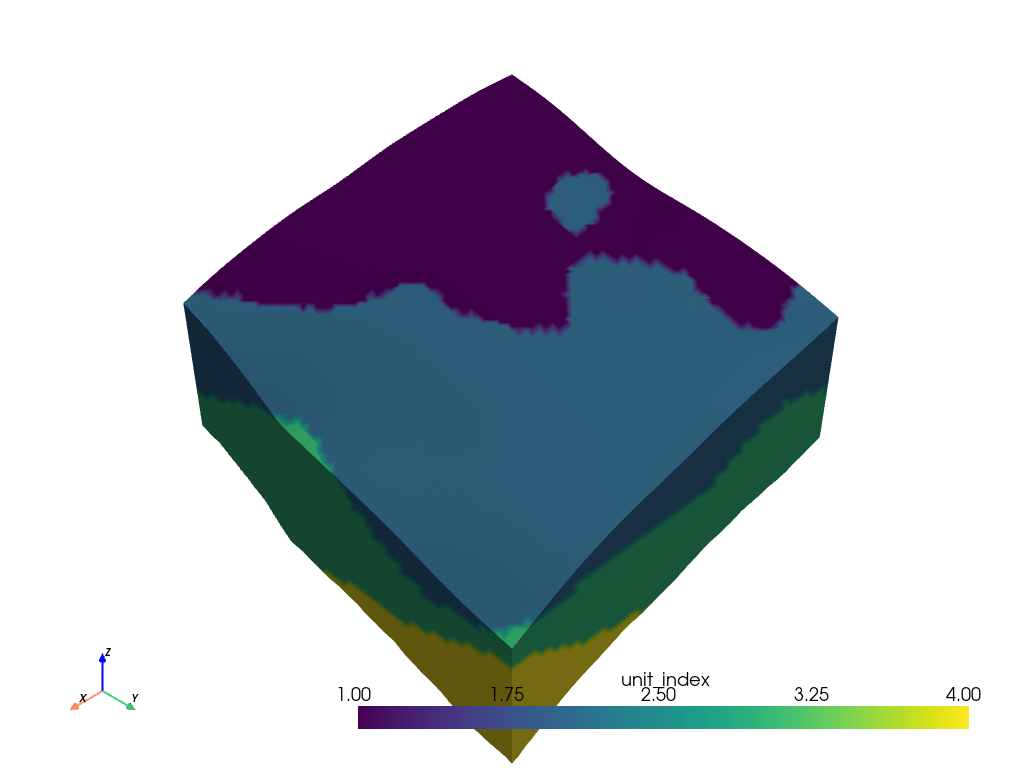

In [22]:
simulated_geology.divide_by_surfaces()
simulated_geology.grid.plot()

To map properties to this domain we can create a dictionary. The dictionary stores the name, and list with mean, and standard deviations for friction angle and cohesion.

In [23]:
properties = {
    1: {
        "name":"Sand and gravel",
        "friction_angle":[35,3],
        "cohesion":[0,0],
    },
    2: {
        "name":"Sand and gravel",
        "friction_angle":[33,2],
        "cohesion":[1,0.1]
    },
    3: {
        "name":"Clay",
        "friction_angle":[23,3],
        "cohesion":[2,0.2]
    },
    4: {
        "name":"Moraine",
        "friction_angle":[23,3],
        "cohesion":[2,0.3]
    },
}

We can then use the helper function random_field which uses gstools Gaussian field generator to generate a random field to give our data some spatial variability. Arguments for the gstools.Gaussian method are specified through kwargs.

In [24]:
kwargs = {
    "dim":3, 
    "len_scale":[30, 30, 1]
    }

random_field_array = random_field(simulated_geology.grid,inplace = True, seed = SEED, **kwargs)


And visualize:

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


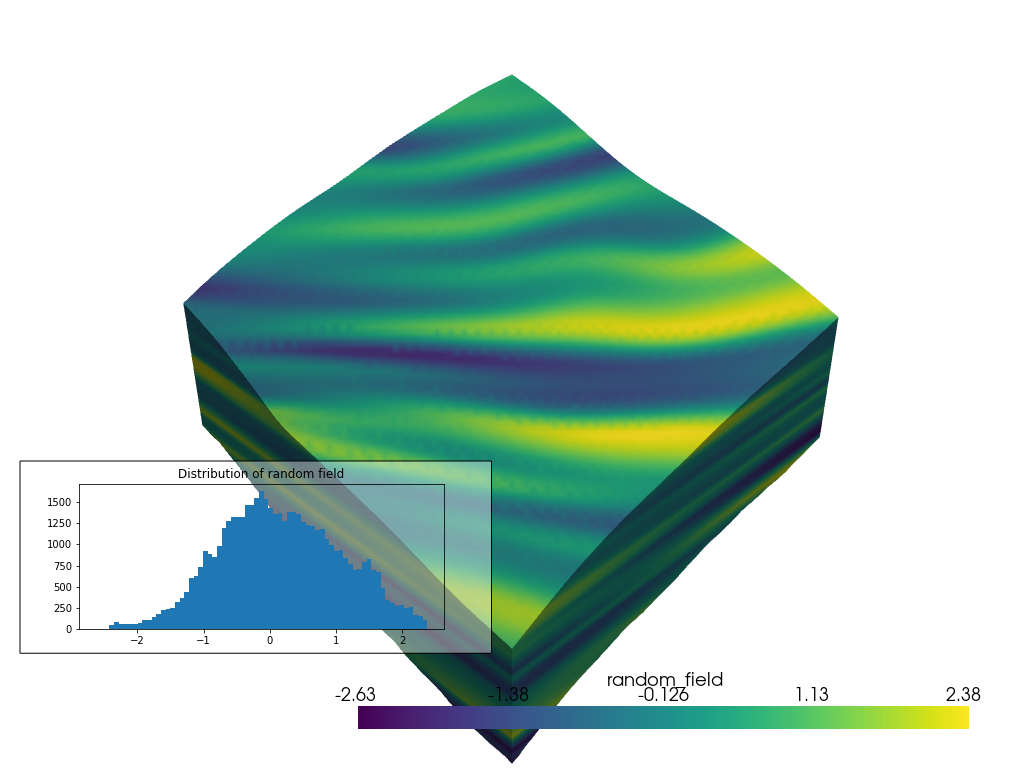

In [25]:
fig, ax = plt.subplots()
ax.hist(np.asarray(random_field_array), bins='auto')  # arguments are passed to np.histogram
ax.set_title("Distribution of random field")
h_chart = pv.ChartMPL(fig, size=(0.46, 0.25), loc=(0.02, 0.15))
h_chart.background_color = (1.0, 1.0, 1.0, 0.4)

plt.close()

simulated_geology.grid.set_active_scalars("random_field")

p = pv.Plotter()
p.add_chart(h_chart)
p.add_mesh(simulated_geology.grid)
p.show()

Then we can map the properties to the random field, and give the simulated_data.grid attribute scalars with spatially distributed cohesions and friction angles according to our random field.

In [26]:
apply_random_field_to_properties(simulated_geology.grid,properties)

And visualize:

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


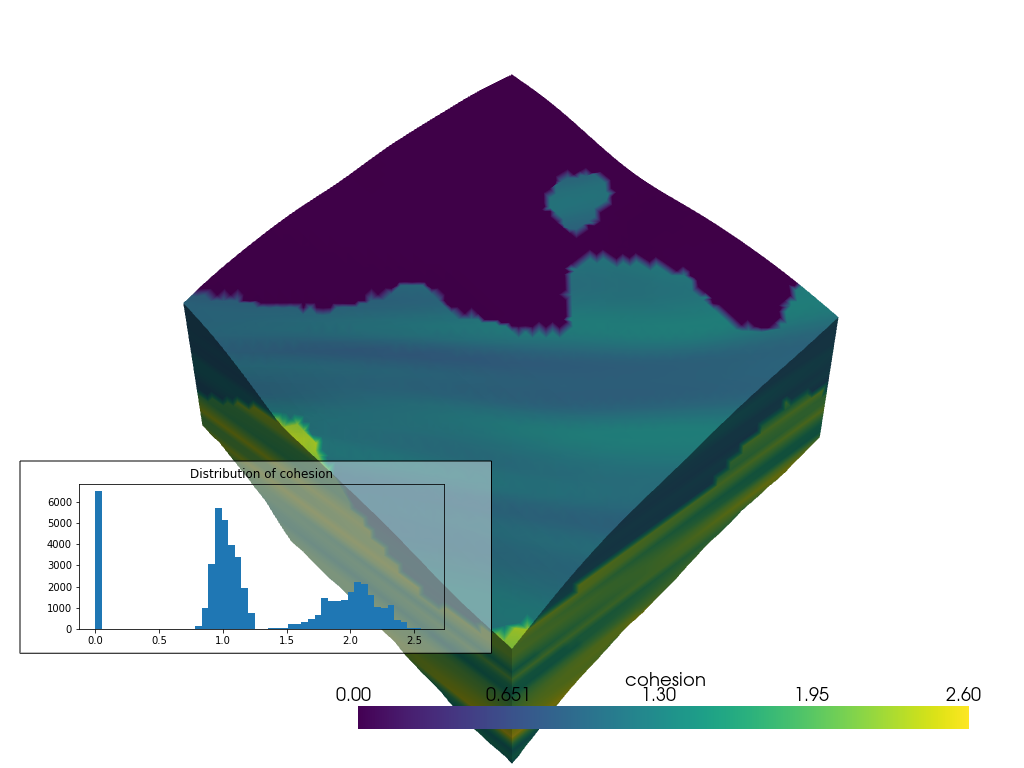

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.asarray(simulated_geology.grid["cohesion"]), bins='auto')  # arguments are passed to np.histogram
ax.set_title("Distribution of cohesion")
h_chart = pv.ChartMPL(fig, size=(0.46, 0.25), loc=(0.02, 0.15))
h_chart.background_color = (1.0, 1.0, 1.0, 0.4)
plt.close()

simulated_geology.grid.set_active_scalars("cohesion")

p = pv.Plotter()
p.add_chart(h_chart)
p.add_mesh(simulated_geology.grid)
p.show()


### Simulate a few boreholes and demonstrate adding downhole data to the investigation

Import the sample_over_line borehole simulator and a visualization utility function

In [27]:
from geotechtoolkit.simulation import sample_over_line
from geotechtoolkit.visualization_utils import investigation_data_to_polydata

Simulate a few boreholes based on the collars. the "sample_over_line" function returns a dataframe

In [28]:
for collar_id in ["LF1","LF2","LF3","LF4"]:
    collar = demo_investigation.collars[demo_investigation.collars["ID"]==collar_id]
    data = sample_over_line(simulated_geology.grid,collar)
    demo_investigation.add_data(data)

polydata = investigation_data_to_polydata(demo_investigation)

demo_investigation.data.head()


,ID,Point,Type,unit_index,random_field,cohesion,friction
0,LF1,POINT Z (20.38 -26.67 -2.5),pv.sample_over_line,2.0,0.016612,1.001661,33.033224
1,LF1,POINT Z (20.38 -26.67 -2.52),pv.sample_over_line,2.0,0.039252,1.003925,33.078504
2,LF1,POINT Z (20.38 -26.67 -2.54),pv.sample_over_line,2.0,0.061892,1.006189,33.123785
3,LF1,POINT Z (20.38 -26.67 -2.56),pv.sample_over_line,2.0,0.084532,1.008453,33.169065
4,LF1,POINT Z (20.38 -26.67 -2.58),pv.sample_over_line,2.0,0.107172,1.010717,33.214345


And visualize:

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


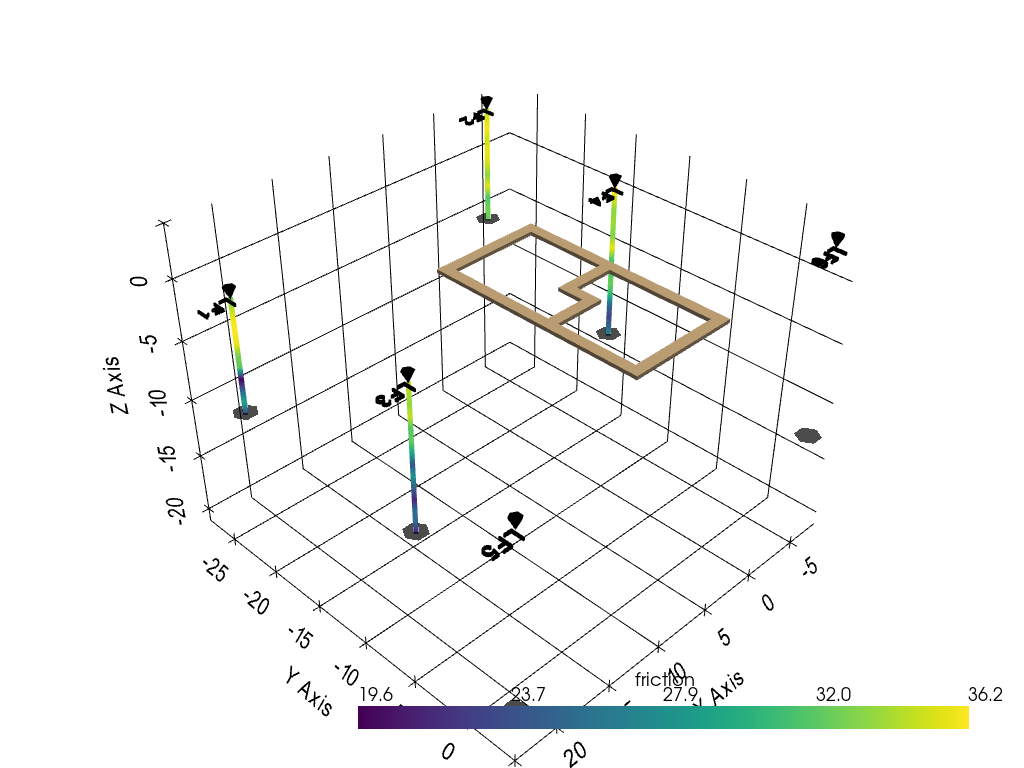

In [29]:

plotter = demo_investigation.plotter()
polydata.set_active_scalars("friction")

plotter = foundations.plotter(plotter)
plotter.add_mesh(polydata)
plotter.show_grid()
plotter.show()

## Statistics for evaluating our interpolated surfaces 
Some functions are available to calculate statistics for evaluating the accuracy of our kriged surface.

The mean squared error for the surface against the original surface that we sampled:

In [ ]:
bedrock_interpolation.interpolation.mean_squared_error(real_surface = sample_bedrock)

1.0831511868152701

We can also calculate the "P-value". In this case we arent checking against a significance limit, which is the typical use of this statistic. In this case it can be interpreted as: Assuming the modeled surface and variances are true, the probability that the real surface is at that location, according to the modeled uncertainty. Low numbers indicate that the model predicted wrong at that location and is overconfident.

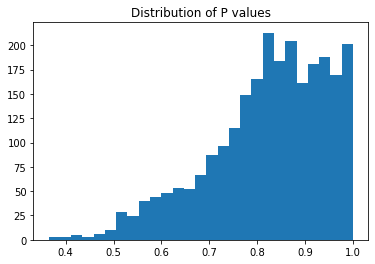

In [ ]:
p_values = bedrock_interpolation.interpolation.two_tailed_test(real_surface = sample_bedrock)

import matplotlib.pyplot as plt
plt.hist(p_values, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of P values")
plt.show()

With this arbitrary investigation the distribution of P values shows that some areas are modeled well, but the model and the data the model was based on didnt pick up on some features of the real surface. The distribution is in general skewed left ("Good", our model predicted accuratley and the results generally fall within the predicted variance). There is however a bit of a bimodal tendency which might indicate that there are some areas that are modeled less accuratley.

We can apply the P values as a scalar field to show the spatial distribution of these less accurate predictions. We see, in fact, that our sampling missed a depression between some of the boreholes, but did pick up on the overall trend of the sloping surface, although missed that the surface leveled off further up dip. In general, we see that we have better P scores near our sampling points, but this is not always the case.

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


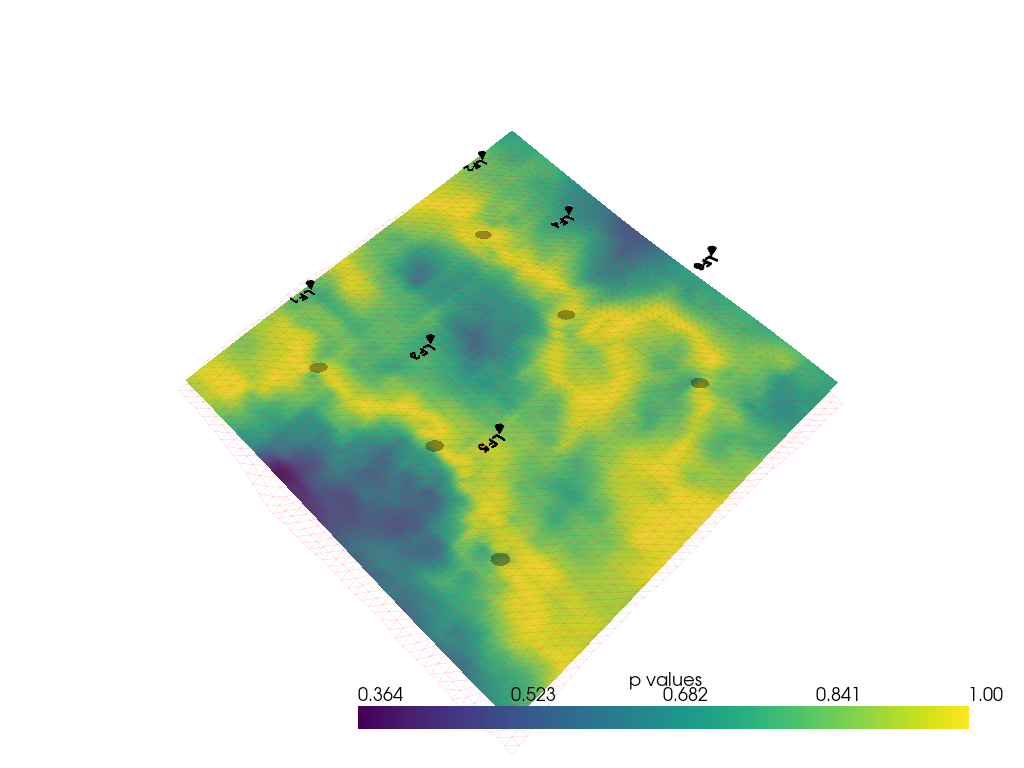

In [ ]:
plotter = demo_investigation.plotter()

plotter.add_mesh(bedrock_edges,color="red",opacity=0.1)

bedrock_interpolation.surface["p values"] = p_values

bedrock_interpolation.surface.set_active_scalars("p values")

plotter.add_mesh(bedrock_interpolation.surface, opacity = 0.9)

plotter.show()


We can then simulate a number of different investigations. Randomly sampling n - number points in r - number realizations in order to evaluate the effects of more boreholes.

In [ ]:
from IPython.utils import io


import contextlib
import random
import numpy as np

from CONSTS import MAX_ELEVATION, MIN_ELEVATION


data = []
realizations = 20
for n in [3, 4, 5, 6, 7 , 8, 9, 10, 11, 12, 13]:
    for r in range(realizations):
        try:
            bedrock_interpolation = Surface("Bedrock")
            X = []
            Y = []
            for _ in range(n):

                x = random.randrange(int(sample_bedrock.bounds[0]), int(sample_bedrock.bounds[1]))
                y = random.randrange(int(sample_bedrock.bounds[2]), int(sample_bedrock.bounds[3]))

                X.append(x)
                Y.append(y)

            X = np.asarray(X)
            Y = np.asarray(Y)


            ones = np.ones(len(X))
            Z_max = ones * MAX_ELEVATION
            Z_min = ones * MIN_ELEVATION
            n_check = True
            while n_check:
                Z = np.asarray(
                    [
                        sample_bedrock.ray_trace([x, y, z_max], [x, y, z_min])[0][0][-1]
                        for x, y, z_max, z_min in zip(X, Y, Z_max, Z_min)
                    ]
                )
                if len(Z)==n:
                    n_check = False

            bedrock_interpolation.krige(
                np.column_stack((X, Y, Z)), domain=sample_bedrock.bounds
            )
            with io.capture_output() as captured:
                data.append(
                    (
                        n,
                        r,
                        np.column_stack((X, Y, Z)),
                        bedrock_interpolation.interpolation.mean_squared_error(
                            real_surface=sample_bedrock
                        ),
                        bedrock_interpolation.interpolation.two_tailed_test(
                            real_surface=sample_bedrock
                        ),
                    )
                )
        except Exception:
            pass
import pandas as pd
df = pd.DataFrame(data, columns = ["Number of samples", "Realization","Points","MSE","P Values"])

Plotiting the MSE for each realization grouped by number of samples.
Filter out 5 outliers #TODO: Investigate why they are outliers

In [ ]:
df2 = df[df["MSE"] < 200]

Visualize the best result

c:\Users\Lucas\anaconda3\envs\geotechtoolkit\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


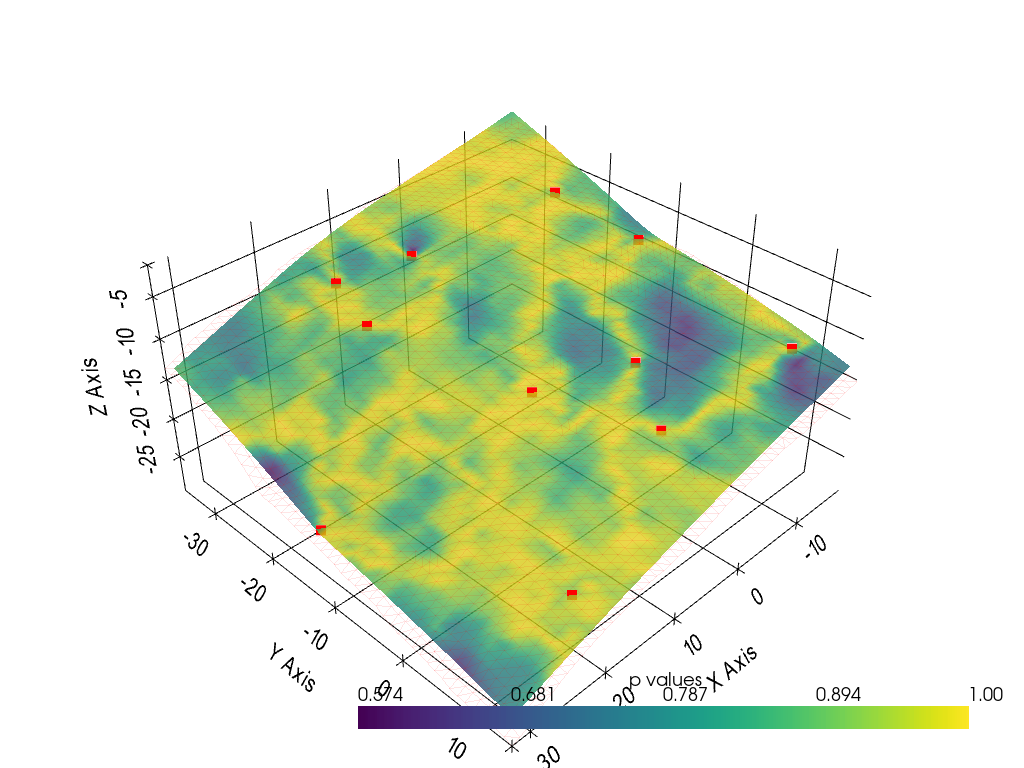

In [ ]:
best_points = df[df["MSE"] == df["MSE"].min()]["Points"].values[0]
bedrock_interpolation.krige(
    best_points, domain=sample_bedrock.bounds
)
points = pv.PolyData(best_points)
plotter = pv.Plotter()
p_values = bedrock_interpolation.interpolation.two_tailed_test(real_surface = sample_bedrock)
plotter.add_mesh(bedrock_edges,color="red",opacity=0.1)
bedrock_interpolation.surface["p values"] = p_values
plotter.add_mesh(bedrock_interpolation.surface, opacity = 0.8)
plotter.add_mesh(points, point_size=10, color = "red")
plotter.show_grid()
plotter.show()

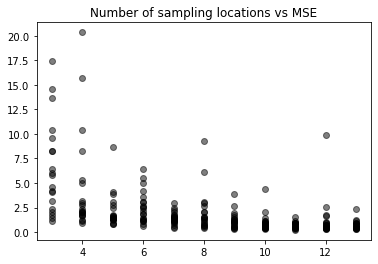

In [ ]:
plt.plot(df2["Number of samples"], df2["MSE"], 'o', color='black',alpha = 0.5)
plt.title("Number of sampling locations vs MSE")
plt.show()

Plotting the distribution of p values for each number of samples. 

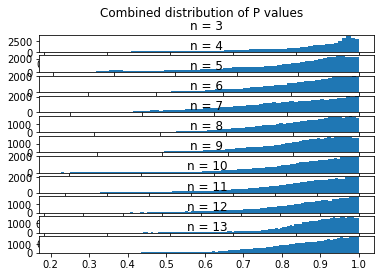

In [ ]:
sampling_numbers = df2["Number of samples"].unique()

fig, axs = plt.subplots(len(sampling_numbers),gridspec_kw={'width_ratios': [2]})
fig.suptitle('Combined distribution of P values')
for i, n in enumerate(sampling_numbers):
    relevant_rows = df2.loc[df['Number of samples']== n]
    values = list(relevant_rows["P Values"])
    values = np.concatenate(values, axis = None)
    values[np.isnan(values)] = 1
    axs[i].set_title(f"n = {n}")
    axs[i].hist(values, bins='auto')
